In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Searching for Optimal Hyperparameters

We’ve explored three classification methods so far: k-nearest neighbors, logistic regression, and decision trees. 
Each of these methods has **hyperparameters**, which are settings that control the behavior of the model (e.g., the number of neighbors in k-NN, the regularization strength in logistic regression, or the depth of a decision tree).
Choosing the right values for these hyperparameters can have a big impact on model performance.

Rather than guessing the best values, we can use **Grid Search** to systematically search for the optimal combination of hyperparameters and improve the model’s performance.

Contents:

- [Grid Search](#1.-Grid-Search)
- [Searching multiple parameters simultaneously](#2.-Searching-multiple-parameters-simultaneously)
- [Randomized Grid Search](#3.-Randomized-Grid-Search:-Randomized-search-on-hyper-parameters)
- [Successive halving](#4.-Optional:-Searching-for-optimal-parameters-with-successive-halving)

Let’s load the Pima Indians Diabetes dataset.
Recall that this dataset contains medical information about Pima Indian women, with the goal of predicting whether a patient has diabetes. 
The features include factors like glucose levels, BMI, age, and more, while the target variable indicates whether the patient has diabetes (1) or not (0).

In [2]:
# load the pima indian dataset
path = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/pima.csv'
df = pd.read_csv(path)
df.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# define X and y
X = df.drop('label',axis=1)
y = df.label

In [4]:
# train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

## 1. Grid Search

We’ll train a k-nearest neighbors (k-NN) model, but instead of guessing the best value for the `n_neighbors` parameter, we want to find the optimal value through a systematic search.

In [5]:
# import and instantiate the knn classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

Scikit-learn provides a function called `GridSearchCV` that automates the process of finding the best hyperparameters. 
It performs an exhaustive search over a specified set of hyperparameter values by trying all combinations and evaluating the model’s performance using cross-validation. 

In [6]:
# import GridSearch
from sklearn.model_selection import GridSearchCV

First, we need to create a parameter grid, which is a dictionary that maps the parameter names to the range of values we want to search. 
In this case, we’ll be searching for the best value of `n_neighbors`, so our parameter grid will look like this:

In [7]:
param_grid = {'n_neighbors': range(1,51)}

This tells GridSearchCV to try values of `n_neighbors` from 1 to 50. 
The model will be trained and evaluated for each of these values.

In [8]:
# instantiate the grid 
grid = GridSearchCV(knn_clf,  
                    param_grid, 
                    cv=10, 
                    scoring='accuracy', 
                    verbose=1, # optional
                    n_jobs=-1) # optional

In the above code:

- `knn_clf`: The model you want to optimize (in this case, k-NN).
- `param_grid`: The dictionary defining the parameters to search, which contains the parameter name (n_neighbors) and the range of values to try.
- `cv=10`: The number of cross-validation folds, where the dataset is split into 10 parts for evaluation. A value between 5 and 10 is typical.
- `scoring='accuracy'`: The evaluation metric to optimize. Here, we are using accuracy, but other metrics (e.g., precision, recall) can be chosen depending on the problem.
- `verbose=1`: Controls how much information is printed during the search process. Higher values give more detailed output. Here’s how different values of verbose affect the output:
    - `verbose=0`: No output is printed during the grid search. It runs silently.
    - `verbose=1`: Basic information is printed, including the number of folds and the progress through the grid search. It will print a line for each combination of parameters tried, but it’s quite minimal.
    - `verbose=2`: More detailed information is printed. You will see the progress for each fold in the cross-validation, not just the overall progress.
    - `verbose=3` : and higher: This gives you even more granular details, including the status of individual model training steps and results for each parameter combination and fold. The higher the number, the more detailed the output becomes. For example, verbose=4 will print a lot of information, including all cross-validation scores, the specific parameters being tested, and progress at every stage.
- `n_jobs=-1`: This tells the function to use all available CPU cores to run the grid search in parallel, speeding up the process.

In [9]:
# fit the grid 
grid.fit(X_train,y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 51)}, scoring='accuracy',
             verbose=1)

In [10]:
# Print the best parameter and score
grid.best_params_

{'n_neighbors': 23}

In [11]:
# Print the best score
grid.best_score_

0.7518451300665456

It looks like the best accuracy, around 75%, was achieved with a k-NN model using 10 neighbors.

We can also take a look at all the scores from the grid search if needed. 
The attribute `grid.cv_results_` contains detailed information about the grid search process.
It stores the results for each combination of hyperparameters tested during the search.
Here’s what’s typically included:

- `mean_fit_time`: The average time taken to fit the model on the training data for each parameter combination.
- `mean_test_score`: The average score (e.g., accuracy) across all cross-validation folds for a specific parameter combination.
- `std_test_score`: The standard deviation of the test score across the cross-validation folds, which gives a sense of how consistent the model’s performance is.
- `params`: The specific parameter values tested for each iteration (e.g., the value of n_neighbors in k-NN).
- `rank_test_score`: The rank of the test score for each parameter combination, where 1 is the best.

I prefer to view this information as a DataFrame rather than a Python dictionary, so I can easily look at the evaluation metric scores and the corresponding parameters.

In [12]:
grid_df = pd.DataFrame(grid.cv_results_)
grid_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012977,0.012568,0.018092,0.015998,1,{'n_neighbors': 1},0.706897,0.689655,0.741379,0.672414,0.741379,0.706897,0.649123,0.666667,0.771930,0.526316,0.687266,0.064657,50
1,0.004320,0.005401,0.008627,0.005871,2,{'n_neighbors': 2},0.689655,0.689655,0.689655,0.775862,0.655172,0.741379,0.701754,0.754386,0.701754,0.631579,0.703085,0.041651,48
2,0.004615,0.004472,0.007378,0.006434,3,{'n_neighbors': 3},0.724138,0.603448,0.637931,0.741379,0.706897,0.775862,0.631579,0.736842,0.701754,0.649123,0.690895,0.053920,49
3,0.008524,0.006542,0.010616,0.014398,4,{'n_neighbors': 4},0.724138,0.724138,0.689655,0.793103,0.706897,0.741379,0.701754,0.789474,0.719298,0.684211,0.727405,0.035806,26
4,0.003658,0.004439,0.007328,0.005084,5,{'n_neighbors': 5},0.741379,0.689655,0.706897,0.741379,0.793103,0.741379,0.684211,0.842105,0.736842,0.684211,0.736116,0.047923,16


In [13]:
grid_df[['mean_test_score', 'params']]

,mean_test_score,params
0,0.687266,{'n_neighbors': 1}
1,0.703085,{'n_neighbors': 2}
2,0.690895,{'n_neighbors': 3}
3,0.727405,{'n_neighbors': 4}
4,0.736116,{'n_neighbors': 5}
5,0.739625,{'n_neighbors': 6}
6,0.743013,{'n_neighbors': 7}
7,0.736025,{'n_neighbors': 8}
8,0.741319,{'n_neighbors': 9}
9,0.739564,{'n_neighbors': 10}


It seems that the accuracy doesn’t change much over a wide range of n_neighbors values. 
However, we can still select the model with the best parameter value.

In [14]:
# model with best hyperparameters
best_clf = grid.best_estimator_

In [15]:
# test your best classifier 
y_test_pred = best_clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_test_pred)

0.7291666666666666

## 2. Searching multiple parameters simultaneously

In addition to the `n_neighbors` parameter, the k-NN model also has a `weights` parameter.
This determines how the model weights the nearest neighbors when making predictions.
The weights parameter can take values like `uniform`, where all neighbors contribute equally, or `distance`, where closer neighbors have more influence.

We can use Grid Search to find the best combination of multiple parameters, such as `n_neighbors` and `weights`, at the same time.

In [16]:
# create a parameter grid dictionary
param_grid = {'n_neighbors': range(1,51), 
              'weights' : ['uniform','distance']}
param_grid

{'n_neighbors': range(1, 51), 'weights': ['uniform', 'distance']}

In [17]:
# instantiate and fit the grid
grid = GridSearchCV(knn_clf,  # classification model
                    param_grid, # parameter grid dictionary
                    cv=10, # number of folds for cross validation
                    scoring='accuracy', # evaluation metric
                    verbose=1, # Controls the verbosity: the higher, the more messages.
                    n_jobs=-1) # use all your CPUs
grid.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 51),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [18]:
# view the results
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'params']]

,mean_test_score,params
0,0.687266,"{'n_neighbors': 1, 'weights': 'uniform'}"
1,0.687266,"{'n_neighbors': 1, 'weights': 'distance'}"
2,0.703085,"{'n_neighbors': 2, 'weights': 'uniform'}"
3,0.687266,"{'n_neighbors': 2, 'weights': 'distance'}"
4,0.690895,"{'n_neighbors': 3, 'weights': 'uniform'}"
...,...,...
95,0.732668,"{'n_neighbors': 48, 'weights': 'distance'}"
96,0.710163,"{'n_neighbors': 49, 'weights': 'uniform'}"
97,0.727465,"{'n_neighbors': 49, 'weights': 'distance'}"
98,0.715426,"{'n_neighbors': 50, 'weights': 'uniform'}"


In [19]:
# examine the best model hyperparameter
print(grid.best_score_)
print(grid.best_params_)

0.7552934059286146
{'n_neighbors': 23, 'weights': 'distance'}


In [20]:
# best knn model
best_clf = grid.best_estimator_

In [21]:
# test your best classifier 
y_test_pred = best_clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_test_pred)

0.7239583333333334

Let’s see if we can outperform the best k-NN model using a decision tree classifier. 
The tricky part of training a decision tree is that it has many hyperparameters, such as `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes`, and `max_features`, each of which can significantly affect the model's performance.

The choice of values and ranges for these hyperparameters is entirely up to you. It depends on the problem you’re solving and how much time you’re willing to spend tuning the model. You can experiment with different ranges to find the combination that works best for your dataset.

Here’s how you can set up a Grid Search for a decision tree classifier:

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the decision tree classifier
tree_clf = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'max_depth': [2,3,4,5,6,7,8,9,10,None],
    'min_samples_split': [10,15,20],
    'min_samples_leaf': [5,10,15],
    'max_leaf_nodes': [None, 10, 20, 30,50],
    'max_features': [None, 'sqrt', 'log2']
}

# Set up the GridSearchCV
grid = GridSearchCV(tree_clf, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the training data
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 10, 20, 30, 50],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [10, 15, 20]},
             scoring='accuracy', verbose=2)

In [24]:
# Print the best parameters and the best score
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

Best parameters: {'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_leaf': 15, 'min_samples_split': 10}
Best cross-validation score: 0.7673463268365817


In [25]:
# test your best classifier 
best_clf = grid.best_estimator_
y_test_pred = best_clf.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.796875

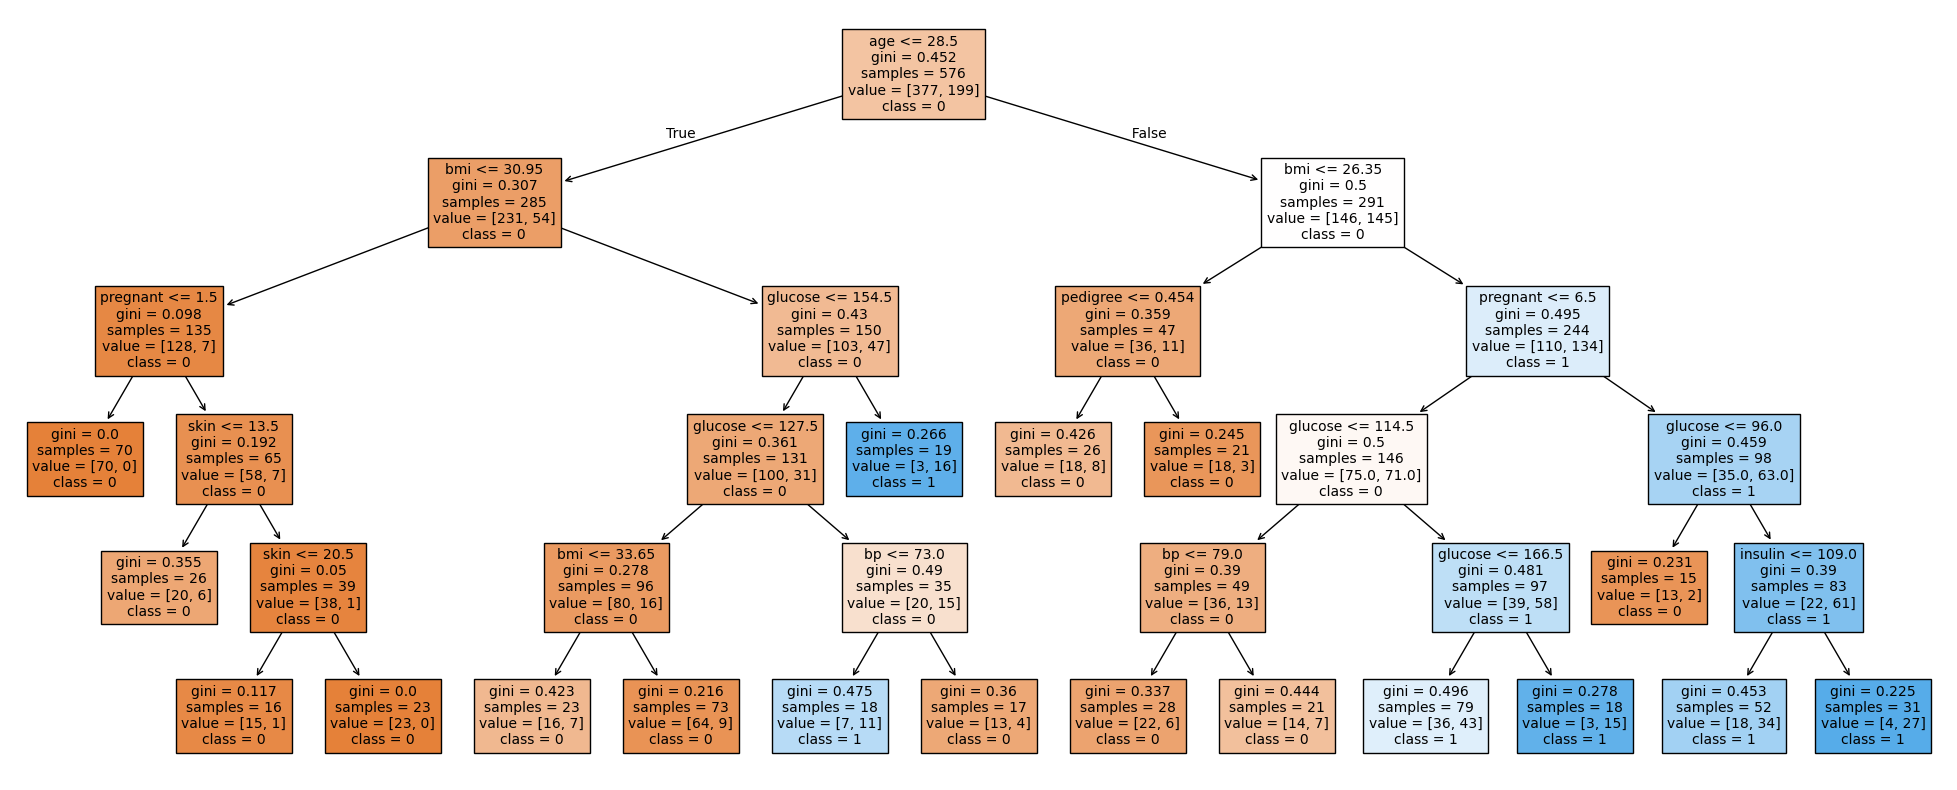

In [27]:
# visualize the tree
from sklearn.tree import plot_tree
plt.figure(figsize=(25,10))
plot_tree(best_clf, 
          feature_names=X.columns, 
          class_names =['0','1'], 
          filled=True, 
          fontsize=10)
plt.show()

Notice how slow the grid search can be. This happens because it has to try out every possible combination of hyperparameter values, which can be time-consuming, especially with large datasets or a wide range of parameters. Can we do better? Yes, by using Randomized Grid Search, which randomly samples from the parameter space, allowing us to search for good combinations more efficiently without testing every single one.

## 3. Randomized Grid Search: Randomized search on hyper parameters

Instead of testing every possible combination of hyperparameters, **Randomized Grid Search** randomly samples from the parameter grid. This is useful when you have a large hyperparameter space and want to explore it efficiently without trying every single combination.

Randomized search selects a fixed number of parameter settings from the grid, making it faster but still effective at finding good combinations.

In [28]:
from sklearn.model_selection import RandomizedSearchCV

In a randomized search, we can be more ambitious and try out a larger variety of hyperparameter values.

In [29]:
param_grid = {
    'max_depth': range(1,11),
    'min_samples_split': range(10,21),
    'min_samples_leaf': range(10,21),
    'max_leaf_nodes': [None, 10, 20, 30,50],
    'max_features': [None, 'sqrt', 'log2']
}

`n_iter=50`: The number of random combinations to try. You can increase or decrease this number depending on how much time you want to spend and how exhaustive you want the search to be.

In [33]:
# Set up the RandomizedSearchCV
grid = RandomizedSearchCV(tree_clf, 
                          param_grid,
                          n_iter=50, 
                          cv=5, 
                          scoring='accuracy', 
                          verbose=1, 
                          n_jobs=-1)

# Fit the randomized search to the training data
grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 11),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': [None, 10, 20, 30,
                                                           50],
                                        'min_samples_leaf': range(10, 21),
                                        'min_samples_split': range(10, 21)},
                   scoring='accuracy', verbose=1)

In [34]:
# Print the best parameters and score
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

Best parameters: {'min_samples_split': 13, 'min_samples_leaf': 11, 'max_leaf_nodes': 50, 'max_features': None, 'max_depth': 6}
Best cross-validation score: 0.758680659670165


In [35]:
# test your best classifier 
best_clf = grid.best_estimator_
y_test_pred = best_clf.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.7447916666666666

## 4. Optional: Searching for optimal parameters with successive halving

**Successive Halving** is another technique for hyperparameter tuning that is more efficient than Grid Search or Randomized Search, especially when dealing with large hyperparameter spaces. Instead of testing all combinations equally, it allocates more resources (training time, data) to better-performing models while gradually eliminating the poorer-performing ones.

The idea is simple: Start by testing several hyperparameter configurations with fewer resources (e.g., fewer data) and progressively focus on the most promising candidates by increasing the resources allocated to them. This allows you to explore many configurations initially but only fully train the best candidates.

These features are still experimental

In [39]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.tree import DecisionTreeClassifier

`factor=2`: This controls how aggressively the search halves the number of candidates. After each round, only the top half of the candidates are selected for the next round, with more resources allocated to them.

In [44]:
grid = HalvingRandomSearchCV(tree_clf, 
                             param_grid, 
                             cv = 5,
                             factor=2, # The ‘halving’ parameter. Factor = 2 means that only half of the combination are selected
                             scoring='accuracy',
                             n_jobs=-1,
                            )
grid.fit(X_train,y_train)

HalvingRandomSearchCV(estimator=DecisionTreeClassifier(), factor=2, n_jobs=-1,
                      param_distributions={'max_depth': range(1, 11),
                                           'max_features': [None, 'sqrt',
                                                            'log2'],
                                           'max_leaf_nodes': [None, 10, 20, 30,
                                                              50],
                                           'min_samples_leaf': range(10, 21),
                                           'min_samples_split': range(10, 21)},
                      scoring='accuracy')

In [45]:
# Print the best parameters and score
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

Best parameters: {'min_samples_split': 14, 'min_samples_leaf': 18, 'max_leaf_nodes': 20, 'max_features': None, 'max_depth': 10}
Best cross-validation score: 0.7281746031746031


In [46]:
# test your best classifier 
best_clf = grid.best_estimator_
y_test_pred = best_clf.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.75